In [1]:
# Import libraries
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import numpy as np
import sklearn
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split,RepeatedKFold,cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectKBest,chi2,SelectFromModel
from sklearn.svm import SVC

# Load Dataset, Inspect Datatypes and check if there are any missing values


In [2]:
# load the dataset
df = pd.read_excel("Data_Scientist_-_Case_Dataset.xlsx",sheet_name=0,sep=",")
# check basic information
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 1 columns):
 #   Column                                                                                                                      Non-Null Count  Dtype 
---  ------                                                                                                                      --------------  ----- 
 0   customer_id,converted,customer_segment,gender,age,related_customers,family_size,initial_fee_level,credit_account_id,branch  891 non-null    object
dtypes: object(1)
memory usage: 7.1+ KB


In [3]:
df.head()

,"customer_id,converted,customer_segment,gender,age,related_customers,family_size,initial_fee_level,credit_account_id,branch"
0,"15001,0,13,male,22.0,1,0,14.5,9b2d5b4678781e53..."
1,"15002,1,11,female,38.0,1,0,142.5666,afa2dc179e..."
2,"15003,1,13,female,26.0,0,0,15.85,9b2d5b4678781..."
3,"15004,1,11,female,35.0,1,0,106.2,abefcf257b5d2..."
4,"15005,0,13,male,35.0,0,0,16.1,9b2d5b4678781e53..."


In [4]:
cols=df.columns[0].split(",")

new_rows=[]
for i, row in df.iterrows():
    for j, column in row.iteritems():
        new_rows.append(column.split(","))
        
dataset=pd.DataFrame(new_rows,columns=cols)
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   customer_id        891 non-null    object
 1   converted          891 non-null    object
 2   customer_segment   891 non-null    object
 3   gender             891 non-null    object
 4   age                891 non-null    object
 5   related_customers  891 non-null    object
 6   family_size        891 non-null    object
 7   initial_fee_level  891 non-null    object
 8   credit_account_id  891 non-null    object
 9   branch             891 non-null    object
dtypes: object(10)
memory usage: 69.7+ KB


In [5]:
# find missing values 
dataset.isnull().sum()

customer_id          0
converted            0
customer_segment     0
gender               0
age                  0
related_customers    0
family_size          0
initial_fee_level    0
credit_account_id    0
branch               0
dtype: int64

### All data types are 'Object' type

In [6]:
# convert the datatypes to correct format, i.e. Numeric where needed to process data properly
dataset['converted']=pd.to_numeric(dataset['converted'], errors='coerce')
dataset['age']=pd.to_numeric(dataset['age'], errors='coerce')
dataset['customer_segment']=pd.to_numeric(dataset['customer_segment'], errors='coerce')
dataset['family_size']=pd.to_numeric(dataset['family_size'], errors='coerce')
dataset['initial_fee_level']=pd.to_numeric(dataset['initial_fee_level'], errors='coerce')
dataset['related_customers']=pd.to_numeric(dataset['related_customers'], errors='coerce')
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   customer_id        891 non-null    object 
 1   converted          891 non-null    int64  
 2   customer_segment   891 non-null    int64  
 3   gender             891 non-null    object 
 4   age                714 non-null    float64
 5   related_customers  891 non-null    int64  
 6   family_size        891 non-null    int64  
 7   initial_fee_level  891 non-null    float64
 8   credit_account_id  891 non-null    object 
 9   branch             891 non-null    object 
dtypes: float64(2), int64(4), object(4)
memory usage: 69.7+ KB


# Handling categorical features

In [7]:
# checking values for column 'gender'
dataset['gender'].unique()

array(['male', 'female'], dtype=object)

In [8]:
# Encoding column 'gender' based on current dataset. And considering other category encoded as 3
def change_val_gender(row):
    if row['gender']=='female':
        return 1
    elif row['gender']=='male':
        return 2
    else:
        return 3

dataset['gender_enc']=dataset.apply(change_val_gender,axis=1)

In [9]:
# checking values for column 'gender'
dataset['branch'].unique()

array(['Helsinki', 'Tampere', 'Turku', ''], dtype=object)

In [10]:
# Encoding column 'branch' based on current dataset. And considering empty category encoded as 4
def change_val_gender(row):
    if row['branch']=='Helsinki':
        return 1
    elif row['branch']=='Tampere':
        return 2
    elif row['branch']=='Turku':
        return 3
    else:
        return 4

dataset['branch_enc']=dataset.apply(change_val_gender,axis=1)

In [11]:
# column 'credit_account_id'
# if customer has none it is shown as 9b2d5b4678781e53038e91ea5324530a03f27dc1d0e5f6c9bc9d493a23be9de0. 
# So using this information to create new column whether the customer has credit account or not
def check_credit_account(row):
    if "9b2d5b4678781e53038e91ea5324530a03f27dc1d0e5f6c9bc9d493a23be9de0" in row['credit_account_id'] :
        return 0
    else:
        return 1
    
dataset['has_credit_account']=dataset.apply(check_credit_account,axis=1)

In [12]:
dataset.head()

,customer_id,converted,customer_segment,gender,age,related_customers,family_size,initial_fee_level,credit_account_id,branch,gender_enc,branch_enc,has_credit_account
0,15001,0,13,male,22.0,1,0,14.5000,9b2d5b4678781e53038e91ea5324530a03f27dc1d0e5f6...,Helsinki,2,1,0
1,15002,1,11,female,38.0,1,0,142.5666,afa2dc179e46e8456ffff9016f91396e9c6adf1fe20d17...,Tampere,1,2,1
2,15003,1,13,female,26.0,0,0,15.8500,9b2d5b4678781e53038e91ea5324530a03f27dc1d0e5f6...,Helsinki,1,1,0
3,15004,1,11,female,35.0,1,0,106.2000,abefcf257b5d2ff2816a68ec7c84ec8c11e0e0dc4f3425...,Helsinki,1,1,1
4,15005,0,13,male,35.0,0,0,16.1000,9b2d5b4678781e53038e91ea5324530a03f27dc1d0e5f6...,Helsinki,2,1,0


## Handle missing and wrong datapoints

In [13]:
# find missing values again after proper formatting of dataframe
dataset.isnull().sum()

customer_id             0
converted               0
customer_segment        0
gender                  0
age                   177
related_customers       0
family_size             0
initial_fee_level       0
credit_account_id       0
branch                  0
gender_enc              0
branch_enc              0
has_credit_account      0
dtype: int64

# Handling the NaNs in the dataframe

In [14]:
# replace NaNs by mean of values in 'age' column
# Not deleting the datapoints to avoid loss of information with regards to other poytential features, since removing the rows with null values removes the whole datapoint
dataset['age'] = dataset['age'].replace(np.nan, dataset['age'].mean())
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 13 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   customer_id         891 non-null    object 
 1   converted           891 non-null    int64  
 2   customer_segment    891 non-null    int64  
 3   gender              891 non-null    object 
 4   age                 891 non-null    float64
 5   related_customers   891 non-null    int64  
 6   family_size         891 non-null    int64  
 7   initial_fee_level   891 non-null    float64
 8   credit_account_id   891 non-null    object 
 9   branch              891 non-null    object 
 10  gender_enc          891 non-null    int64  
 11  branch_enc          891 non-null    int64  
 12  has_credit_account  891 non-null    int64  
dtypes: float64(2), int64(7), object(4)
memory usage: 90.6+ KB


In [15]:
dataset.groupby('age')['age'].count()

age
0.42     1
0.67     1
0.75     2
0.83     2
0.92     1
        ..
70.00    2
70.50    1
71.00    2
74.00    1
80.00    1
Name: age, Length: 89, dtype: int64

In [16]:
# correcting the wrong entries and rounding up the numbers
def correct_age(row):
    if row['age']<1 and row['age']>0:
        return row['age']*100
    else:
        #return row['age']
        return round(row['age'])

dataset['age']=dataset.apply(correct_age,axis=1)

In [17]:
# binning the age into groups by decade
dataset['age_by_decade'] = pd.cut(x=dataset['age'], bins=[0,10,20, 29, 39, 49,59,69,79,89,99], labels=['10s','20s', '30s', '40s','50s','60s','70s','80s','90s','100s'])

In [18]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 14 columns):
 #   Column              Non-Null Count  Dtype   
---  ------              --------------  -----   
 0   customer_id         891 non-null    object  
 1   converted           891 non-null    int64   
 2   customer_segment    891 non-null    int64   
 3   gender              891 non-null    object  
 4   age                 891 non-null    float64 
 5   related_customers   891 non-null    int64   
 6   family_size         891 non-null    int64   
 7   initial_fee_level   891 non-null    float64 
 8   credit_account_id   891 non-null    object  
 9   branch              891 non-null    object  
 10  gender_enc          891 non-null    int64   
 11  branch_enc          891 non-null    int64   
 12  has_credit_account  891 non-null    int64   
 13  age_by_decade       891 non-null    category
dtypes: category(1), float64(2), int64(7), object(4)
memory usage: 91.9+ KB


# Find correlations using Pearson Correlation Coefficient

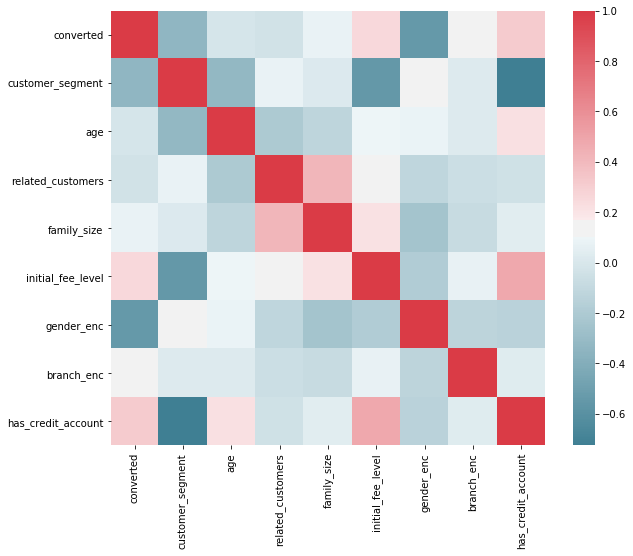

In [19]:
# run correlation matrix and plot
f, ax = plt.subplots(figsize=(10, 8))
corr = dataset.corr()
sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool),
            cmap=sns.diverging_palette(220, 10, as_cmap=True),
            square=True, ax=ax)

In [20]:
display(corr)

,converted,customer_segment,age,related_customers,family_size,initial_fee_level,gender_enc,branch_enc,has_credit_account
converted,1.000000,-0.338481,-0.013987,-0.035322,0.081629,0.257307,-0.543351,0.118026,0.316912
customer_segment,-0.338481,1.000000,-0.326508,0.083081,0.018443,-0.549500,0.131900,0.028566,-0.725541
age,-0.013987,-0.326508,1.000000,-0.205197,-0.124175,0.097360,0.087789,0.025600,0.220064
related_customers,-0.035322,0.083081,-0.205197,1.000000,0.414838,0.159651,-0.114631,-0.063794,-0.040460
family_size,0.081629,0.018443,-0.124175,0.414838,1.000000,0.216225,-0.245489,-0.082144,0.036987
initial_fee_level,0.257307,-0.549500,0.097360,0.159651,0.216225,1.000000,-0.182333,0.071010,0.482075
gender_enc,-0.543351,0.131900,0.087789,-0.114631,-0.245489,-0.182333,1.000000,-0.128526,-0.140391
branch_enc,0.118026,0.028566,0.025600,-0.063794,-0.082144,0.071010,-0.128526,1.000000,0.032614
has_credit_account,0.316912,-0.725541,0.220064,-0.040460,0.036987,0.482075,-0.140391,0.032614,1.000000


# (chi²) statistical test for best features selection

In [21]:
# Using the chi-squared (chi²) statistical test for non-negative features to select 5 best features


X = dataset[["age","initial_fee_level","has_credit_account","gender_enc","customer_segment","family_size","related_customers","branch_enc"]
           ]
y = dataset["converted"]

# apply SelectKBest class to extract top 5 best features
bestfeatures = SelectKBest(score_func=chi2, k=5)
fit = bestfeatures.fit(X,y)
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(X.columns)
# concat two dataframes for better visualization 
featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['Specs','Score']  #naming the dataframe columns
print(featureScores.nlargest(10,'Score'))  #print 10 best features

                Specs        Score
1   initial_fee_level  9036.638181
2  has_credit_account    68.997412
3          gender_enc    36.436861
5         family_size    10.097499
4    customer_segment     5.790754
7          branch_enc     3.800456
6   related_customers     2.581865
0                 age     1.028669


# Using visualizations for some features to observe correlations

## Gender and Customers converted

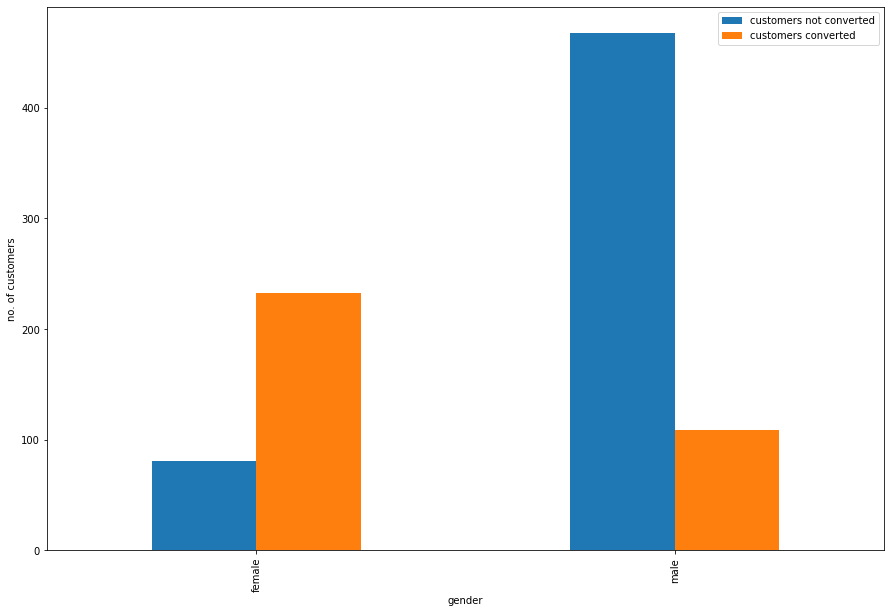

In [22]:
gender_patterns=dataset.groupby(['gender','converted'])['customer_id'].count()
gender_patterns_df = pd.DataFrame(gender_patterns.unstack(level = 1))
gender_patterns_df.plot(kind='bar',figsize=(15,10))
plt.legend(['customers not converted','customers converted'])
plt.ylabel('no. of customers')

plt.show()

## Initial fee level and customers converted

In [23]:
# binning initial fee level among different fee groups

## Assumption : There are few rows where values for initial_fee_level is 0. 
## It is assumed that it probably has given as free trial to customers as promotional offer or new customer benefits.

dataset['initial_fee_group'] = pd.cut(x=dataset['initial_fee_level'], bins=[-1,0,20,50,100,200,500,1000], labels=['free trial','less than 20','20-50','50-100','100-200','200-500','500-1000'])

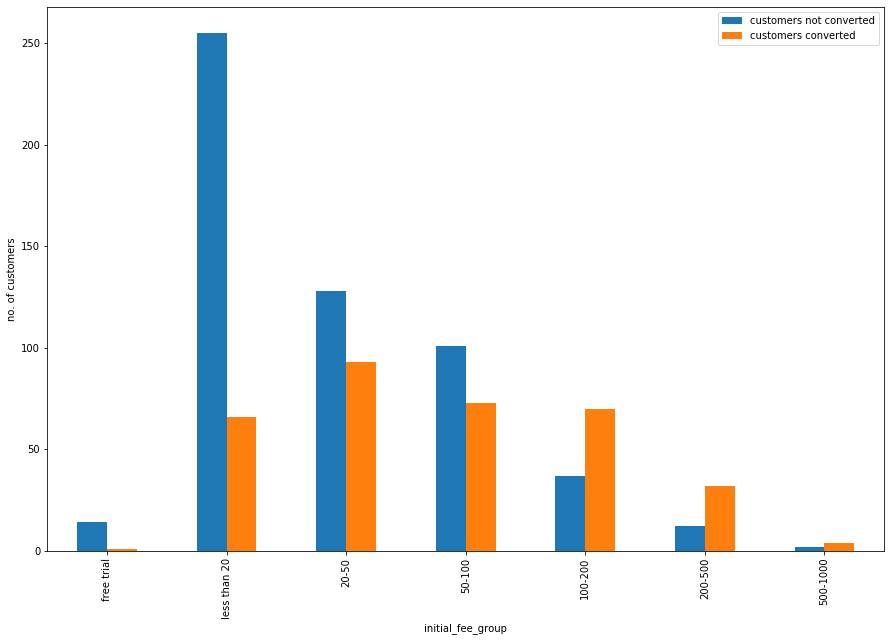

In [24]:
initial_fee_patterns=dataset.groupby(['initial_fee_group','converted'])['customer_id'].count()
initial_fee_patterns_df = pd.DataFrame(initial_fee_patterns.unstack(level = 1))
initial_fee_patterns_df.plot(kind='bar',figsize=(15,10))
plt.legend(['customers not converted','customers converted'])
plt.ylabel('no. of customers')

plt.show()

# Relationship between Customers converted and customer_segment

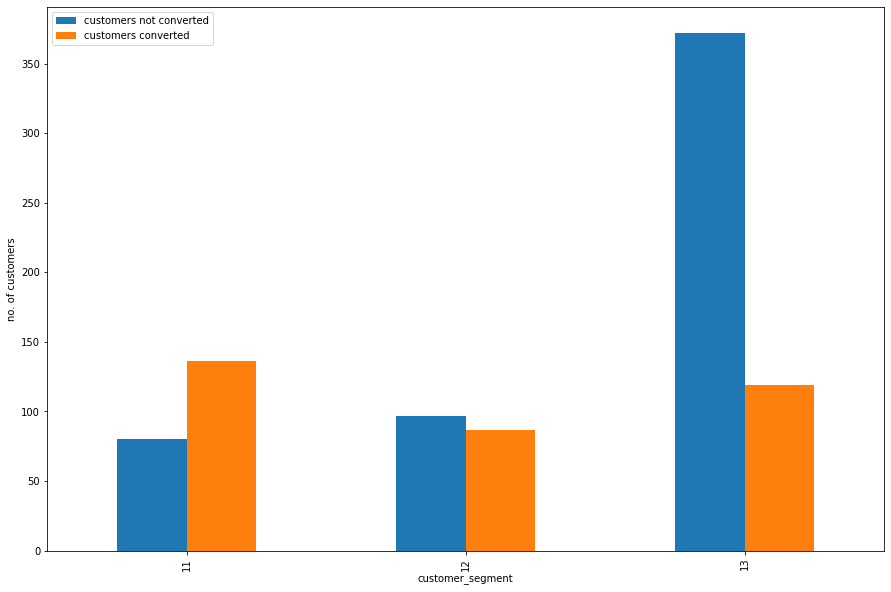

In [25]:
segment_patterns=dataset.groupby(['customer_segment','converted'])['customer_id'].count()
segment_patterns_df = pd.DataFrame(segment_patterns.unstack(level = 1))
segment_patterns_df.plot(kind='bar',figsize=(15,10))
plt.legend(['customers not converted','customers converted'])
plt.ylabel('no. of customers')

plt.show()

## Relationship among credit account, age and converted

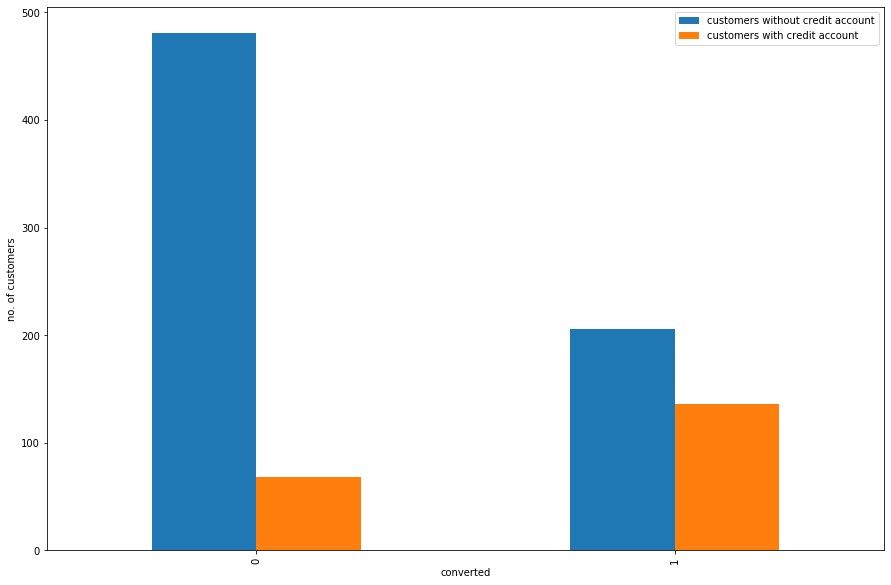

In [26]:
credit_patterns=dataset.groupby(['converted','has_credit_account'])['customer_id'].count()
credit_patterns_df = pd.DataFrame(credit_patterns.unstack(level = 1))
credit_patterns_df.plot(kind='bar',figsize=(15,10))
plt.legend(['customers without credit account','customers with credit account'])
plt.ylabel('no. of customers')

plt.show()

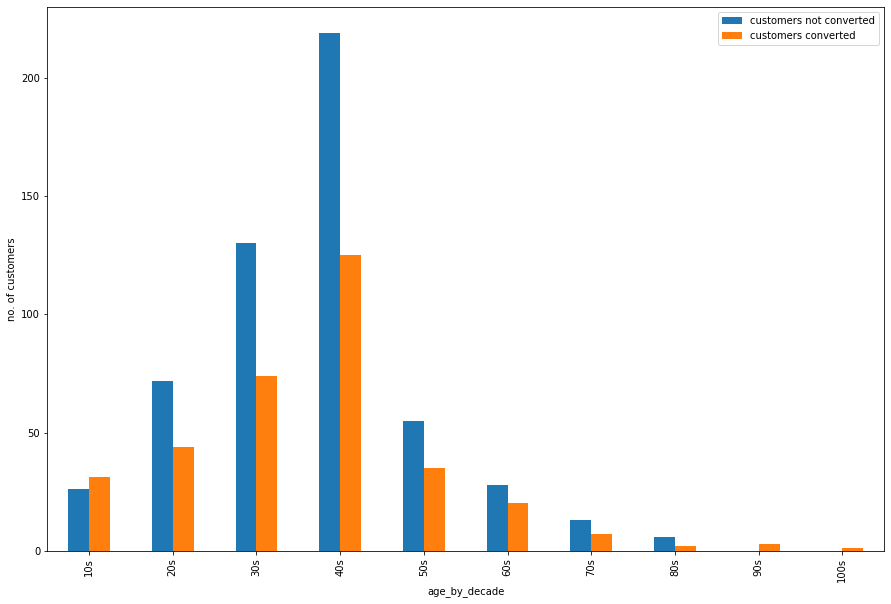

In [27]:
age_patterns=dataset.groupby(['age_by_decade','converted'])['customer_id'].count()
age_patterns_df = pd.DataFrame(age_patterns.unstack(level = 1))
age_patterns_df.plot(kind='bar',figsize=(15,10))
plt.legend(['customers not converted','customers converted'])
plt.ylabel('no. of customers')

plt.show()

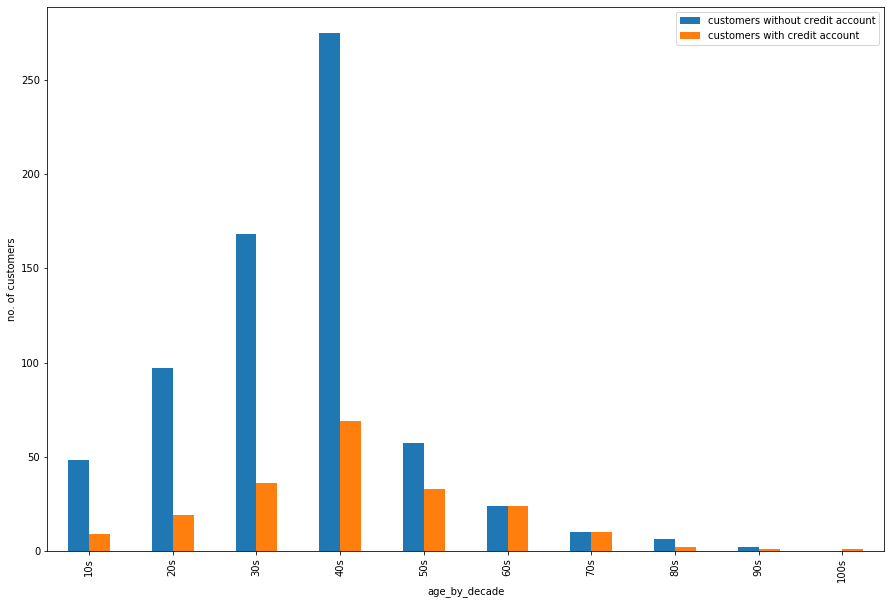

In [28]:
age_credit_patterns=dataset.groupby(['age_by_decade','has_credit_account'])['customer_id'].count()
age_credit_patterns_df = pd.DataFrame(age_credit_patterns.unstack(level = 1))
age_credit_patterns_df.plot(kind='bar',figsize=(15,10))
plt.legend(['customers without credit account','customers with credit account'])
plt.ylabel('no. of customers')

plt.show()

## Family size, related customers and converted

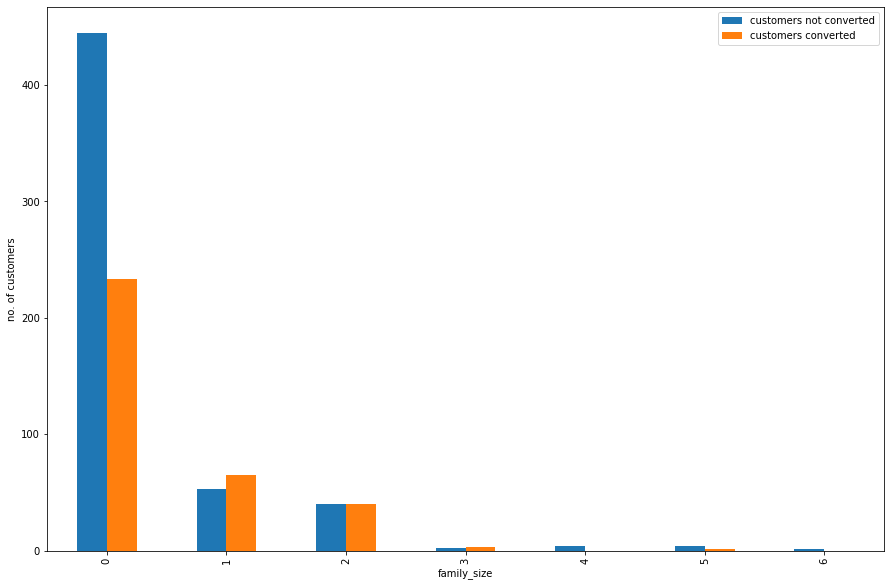

In [29]:
family_size_patterns=dataset.groupby(['family_size','converted'])['customer_id'].count()
family_size_patterns_df = pd.DataFrame(family_size_patterns.unstack(level = 1))
family_size_patterns_df.plot(kind='bar',figsize=(15,10))
plt.legend(['customers not converted','customers converted'])
plt.ylabel('no. of customers')

plt.show()

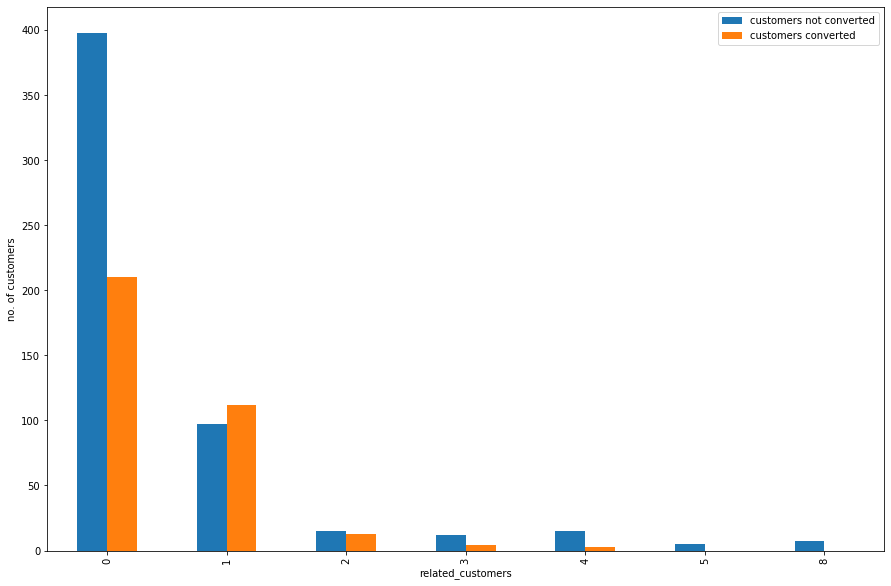

In [30]:
related_customers_patterns=dataset.groupby(['related_customers','converted'])['customer_id'].count()
related_customers_patterns_df = pd.DataFrame(related_customers_patterns.unstack(level = 1))
related_customers_patterns_df.plot(kind='bar',figsize=(15,10))
plt.legend(['customers not converted','customers converted'])
plt.ylabel('no. of customers')

plt.show()

# Hypothesis Testing for the feature selection 

## Class Distribution for 'converted' class

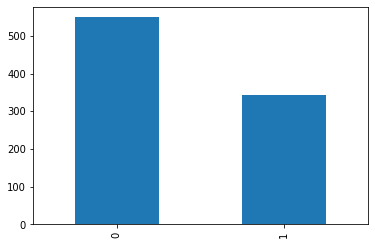

In [31]:
labels = dataset['converted']
labels.value_counts().plot(kind="bar")

In [32]:
labels.value_counts(normalize=True)

0    0.616162
1    0.383838
Name: converted, dtype: float64

## Scaling Continuous features

In [33]:
# Scaling only continuous features using MinMaxScaler, 
# it is a type of normalization where the values will range between 0 and 1 and 
# X_Norm = (X - X_Min) / (X_Max - X_Min).
continuous_features = ['age','initial_fee_level']
scaler = MinMaxScaler()
df_norm = dataset.copy()
dataset[continuous_features] = scaler.fit_transform(dataset[continuous_features])

In [34]:
# separate dataframe into selected features and labels
features = dataset[["gender_enc","age","initial_fee_level","customer_segment","family_size","has_credit_account"]]#,"related_customers","branch_enc"]]
result = dataset["converted"]

In [35]:
# split dataset into training and test set
X_train, X_test, y_train, y_test = train_test_split(features, result, test_size = 0.2, random_state = 14)

# Random Forest using all selected features 

In [36]:
# Random forest classifier
random_forest = RandomForestClassifier()
random_forest.fit(X_train, y_train)
# Making predictions on unseen data
predictions_rf = random_forest.predict(X_test)

([0, 1, 2, 3, 4, 5], <a list of 6 Text xticklabel objects>)

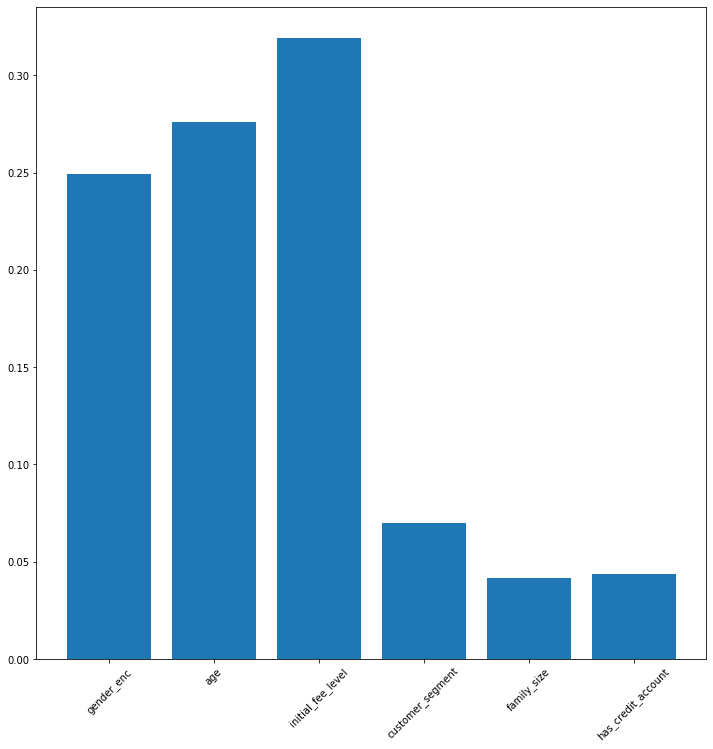

In [37]:
# what features are the most important?
# x axis is features, and Y indicating the importance of each feature
plt.figure(figsize=(12,12))
plt.bar(features.columns, random_forest.feature_importances_)
plt.xticks(rotation=45)

In [38]:
# View a list of the features and their importance scores
list(zip(features, random_forest.feature_importances_))

[('gender_enc', 0.2490838148179752),
 ('age', 0.2762836390971149),
 ('initial_fee_level', 0.31938105639546155),
 ('customer_segment', 0.0701295302334938),
 ('family_size', 0.04165522557365535),
 ('has_credit_account', 0.04346673388229922)]

In [39]:
# function for model evaluation,producting confusion matrix, precision and recall score
def evaluate_model(label,predictions):
    print("confusion matrix:")
    cm= confusion_matrix(label, predictions)
    print(cm)
    tp_and_fn = cm.sum(1)
    tp_and_fp = cm.sum(0)
    tp = cm.diagonal()

    precision = tp / tp_and_fp
    recall = tp / tp_and_fn
    print('Precision: {}\nRecall: {}'.format(precision, recall))
    print('Accuracy:', accuracy_score(label, predictions))

In [40]:
# Evaluate random forest predictions with all the features
evaluate_model(y_test, predictions_rf)

confusion matrix:
[[97 18]
 [15 49]]
Precision: [0.86607143 0.73134328]
Recall: [0.84347826 0.765625  ]
Accuracy: 0.8156424581005587


## Model with Important features using importance score

In [41]:
# Create a selector object that will use the random forest classifier to identify
# features that have an importance of more than 0.06
random_forest = RandomForestClassifier()
model = SelectFromModel(random_forest, threshold=0.06)

# Train the selector
model.fit(X_train, y_train)
labels = list(features.columns.values) # creating a list with features' names
print("Selected features : ")
for feature_list_index in model.get_support(indices=True):
    print(labels[feature_list_index])
    

# Training only with important features. 
X_important_train = model.transform(X_train)
X_important_test = model.transform(X_test)
random_forest_important = RandomForestClassifier(n_estimators=10000, random_state=0, n_jobs=-1)
random_forest_important.fit(X_important_train, y_train)
predictions_imp = random_forest_important.predict(X_important_test)

# evaluate model with important features
evaluate_model(y_test,predictions_imp)

Selected features : 
gender_enc
age
initial_fee_level
customer_segment
confusion matrix:
[[102  13]
 [ 15  49]]
Precision: [0.87179487 0.79032258]
Recall: [0.88695652 0.765625  ]
Accuracy: 0.8435754189944135


# Testing with different models

## Logistic regression  

In [42]:
logmodel = LogisticRegression(solver='liblinear')
logmodel.fit(X_train, y_train)
predictions_lr = logmodel.predict(X_test)
evaluate_model(y_test,predictions_lr)

confusion matrix:
[[96 19]
 [19 45]]
Precision: [0.83478261 0.703125  ]
Recall: [0.83478261 0.703125  ]
Accuracy: 0.7877094972067039


## Using weight from the class distribution 

In [43]:
class_wts = dataset['converted'].value_counts(normalize = True)
weights = {0 : class_wts[0], 1 : class_wts[1]}
logmodel_auto = LogisticRegression(class_weight = weights, solver = 'liblinear')
logmodel_auto.fit(X_train, y_train)
predictions_std_auto = logmodel_auto.predict(X_test)
evaluate_model(y_test,predictions_std_auto)

confusion matrix:
[[101  14]
 [ 23  41]]
Precision: [0.81451613 0.74545455]
Recall: [0.87826087 0.640625  ]
Accuracy: 0.7932960893854749


## Using K fold cross validation 

In [44]:
X = X_important_train
y = y_train

cv = RepeatedKFold(n_splits=5, n_repeats= 100, random_state=1)
model = LogisticRegression()

# getting misclassification rate
scores = 1 - cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1)
model.fit(X_train, y_train)
predictions_kfold = model.predict(X_test)
evaluate_model(y_test,predictions_kfold)

confusion matrix:
[[97 18]
 [19 45]]
Precision: [0.8362069  0.71428571]
Recall: [0.84347826 0.703125  ]
Accuracy: 0.7932960893854749


## SVM Model

In [45]:
svc=SVC() # The default kernel used by SVC is the gaussian kernel
svc.fit(X_train, y_train)
prediction = svc.predict(X_test)
evaluate_model(y_test,prediction)

confusion matrix:
[[96 19]
 [19 45]]
Precision: [0.83478261 0.703125  ]
Recall: [0.83478261 0.703125  ]
Accuracy: 0.7877094972067039
